## 모듈 설치

In [1]:
import tensorflow as tf
from tqdm.notebook import tqdm
# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import collections
import random
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

# 데이터 다운로드

In [4]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip',
                                          extract = True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2017.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2017/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2017.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2017.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

## 경로 지정

In [2]:
train_PATH="/home/seeds/iconms12/tmp/tf_image_captioning/train2017/"
test_PATH="/home/seeds/iconms12/tmp/tf_image_captioning/test2017/"
train_annotation_file = "/home/seeds/iconms12/tmp/tf_image_captioning/annotations/captions_train2017.json"
test_annotation_file = "/home/seeds/iconms12/tmp/tf_image_captioning/annotations/captions_val2017.json"
image_folder = '/train2017/'

In [3]:
with open(train_annotation_file, 'r') as f:
    annotations = json.load(f)

In [4]:
image_path_to_caption = collections.defaultdict(list) #다운로드 받은 이미지_캡션 데이터
for val in annotations['annotations']:
    image_path = train_PATH + '%012d.jpg' % (val['image_id'])
    caption = f"<start> {val['caption']} <end>"
    image_path_to_caption[image_path].append(caption)
    
    
f=open('rf1.txt', 'r') #추가 이미지 및 캡션 데이터
for line in f:
    a=line.split(",")
    image_path=train_PATH + a[0]
    caption=f"<start> {a[1]} <end>"
    caption=caption.replace("\n"," ")
    image_path_to_caption[image_path].append(caption)

In [5]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths) #이미지 섞기

train_image_paths = image_paths
print(len(train_image_paths)) #총 이미지의 개수

118344


In [6]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]  #이미지의 캡션 5개 변수할당
  train_captions.extend(caption_list) #1차원 벡터로 이미지 캡션 5개씩 확장
  img_name_vector.extend([image_path] * len(caption_list)) #이미지 이름이 캡션에 매칭될수있도록 5배씩 확장하여 1차원 벡터에 할당

In [7]:
with open('train_captions.pkl', 'wb') as f: #만들어진 데이터셋 pickel로 저장
    pickle.dump(train_captions, f)

<start> A young guy is sitting on a sofa in a living room with a laptop beside him.  <end>


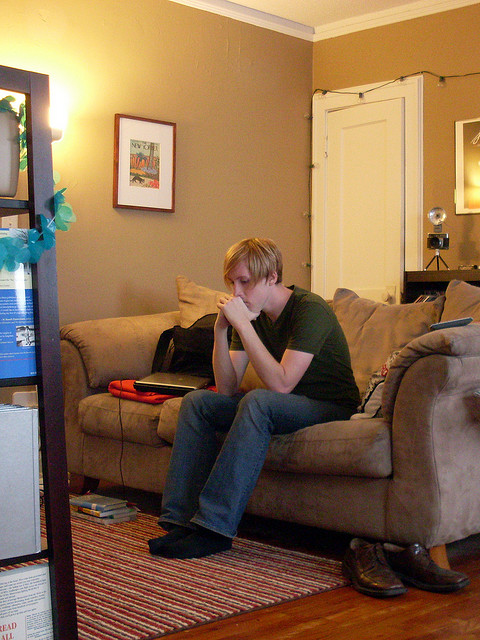

In [8]:
print(train_captions[0])
Image.open(img_name_vector[0])

## 이미지 불러오기 (전처리)

In [9]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## IncceptionV3를 사용하여 사전학습된 image Net의 가중치를 가져와 학습

In [10]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
#299,299,3 의 데이터를 
#(64,2048)의 크기의 텐서로 변환

## 이미지 데이터 처리 Inception_V3를 이용

In [11]:
encode_train = sorted(set(img_name_vector))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset): #이미지 데이터
  batch_features = image_features_extract_model(img) #각 특징값을 잡아서 추출
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8") #바이너리화 되있는 경로를 decoding후 할당
    np.save(path_of_feature, bf.numpy()) #추출된 데이터들을 저장시킴

A Jupyter Widget

## 토크나이저를 사용한 캡션 데이터 전처리 과정

In [12]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor) 
#가장 길이가 큰 문장에 맞춰 pad를 할당할수있게끔 가장길이가 긴 문장을 찾는 함수

In [13]:

top_k = 10000  #15000개의 단어만을 vocab에서 사용하게끔 함
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions) #문장을 토크나이저를 통하여 학습후
train_seqs = tokenizer.texts_to_sequences(train_captions) #학습된 토크나이저가 문장 리스트를 seqs형태로 저장시킴


In [14]:
tokenizer.word_index['<pad>'] = 0 #문장의 길이를 맞추는 PAD를 idx 0에 저장
tokenizer.index_word[0] = '<pad>'

In [15]:
train_seqs = tokenizer.texts_to_sequences(train_captions)  #토크나이저 벡터 생성

In [16]:
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post') #pad를 앞에서 부터저장

# 각 벡터를 캡션의 max_length까지 채 웁니다.
# max_length 값을 제공하지 않으면 pad_sequences가 자동으로 계산합니다.

In [17]:
max_length = calc_max_length(train_seqs) 
#가중치를 저장하는 데 사용되는 max_length를 계산합니다.

In [18]:
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f) #토크나이저 추출

## 훈련셋과 테스트셋 나눔

In [19]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)


img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8) #훈련셋 80% 테스트셋 20%
img_name_train_keys, img_name_val_keys = img_keys[:slice_index] , img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [20]:
BATCH_SIZE = 256 #한번에 네트워크에 넘겨주는 데이터의 수 64개
BUFFER_SIZE = 1000 #고정된 버퍼를 사용하여 항목이 통과할때 순서를 섞는다.
embedding_dim = 256 #임베딩 차원
units = 512 #노드 개수는 512개
vocab_size = top_k + 1 #사전크기 50000개 
num_steps = len(img_name_train) // BATCH_SIZE # 4000 // 64 만큼의 스탭을 반복하여 1epoch의 학습을 진행함
v_num_steps = len(img_name_val) // BATCH_SIZE

#InceptionV3에서 추출한 벡터의 모양은 (64, 2048)
features_shape = 2048 #특징 크기
attention_features_shape = 64 #주의 해야할 특징 크기

In [21]:
# 위에서 저장해둔 특징값 넘파이를 불러와 저장
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [22]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)
#dataset의 첫번째 값은 img_tensor(특징값),두번째는 caption

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

v_dataset = tf.data.Dataset.from_tensor_slices((img_name_val, cap_val))


v_dataset = v_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# 섞고 배치하기
v_dataset = v_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
v_dataset = v_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [23]:
len(v_dataset)

463

## 모델

In [24]:
class BahdanauAttention(tf.keras.Model): #디코더가 스스로 어떤 벡터에 중점을 둬서 정보를 취할지 선택
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units) #은닉층 출력뉴런 512
    self.W2 = tf.keras.layers.Dense(units) #은닉층 출력뉴런 512
    self.V = tf.keras.layers.Dense(1) #출력층 출력 뉴런 1

  def call(self, features, hidden):
    #score 계산을 위해 뒤에서 할 덧셈을 위해서 차원을 변경해줍니다
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))
    #attention_hidden_layer=(256,64,512)

    score = self.V(attention_hidden_layer) #출력층에서 나오는값

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [25]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim) #256,64,256

    def call(self, x):
        x = self.fc(x) #함수호출시 입력값을 fc를  통해 출력한뒤 
        x = tf.nn.relu(x) #출력값이 0보다 작으면 0으로 0보다크다면 그대로 출력하는 활성화 함수를 통해
        return x #반환한다.

In [26]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim) #vocab size= 15001개 pad포함
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform') #gru와 LSTM의 성능은 유사하나 속도면에서 차이가큼
    #512
    self.fc1 = tf.keras.layers.Dense(self.units) #512
    self.fc2 = tf.keras.layers.Dense(vocab_size) #15001

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # 어텐션을 별도의 모델로 정의 
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x) #15001개의 단어를 256개의 텐서로 임베딩

    # x shape (256, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x) #sequences와 state반환

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output) #워드 sequence를 입력하여 x로 반환

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2])) #x의 형태 변환

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x) #반환

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units)) #초기화시 (1,512)의 텐서로 반환

In [27]:
encoder = CNN_Encoder(embedding_dim) #256 임베딩
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [28]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## 세이브

In [29]:

checkpoint_path = "./checkpoints/final_model1"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

## 로드

In [30]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [31]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []
v_loss_plot = []

In [32]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [33]:
def loss_step(img_tensor, target):
    loss = 0
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    features = encoder(img_tensor)
    for i in range(1, target.shape[1]):
        predictions, hidden, _ = decoder(dec_input, features, hidden)
        loss += loss_function(target[:, i], predictions)

    total_loss = (loss / int(target.shape[1]))
    return loss, total_loss

In [34]:
import spacy
from tqdm.notebook import tqdm
import nltk.translate.bleu_score as bleu
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

def l1_normalize(v): #각 벡터안의 요소값을 모두 더한 것의 크기가 1이 되도록 벡터의 크기를 조절하는 방법
    norm = np.sum(v)
    return v / norm
    
    
def print_caption(): 
    cosin_list=[]
    euclidean_list=[]
    manhattan_list=[]
    ref1=[]
    ref=[]
    hyp=[]
    for j in tqdm(range(len(img_name_val))):
        image = img_name_val[j]
        t=[tokenizer.index_word[i] for i in cap_val[j] if i not in [0]]
        real_caption = t[1:-1]
        ref.append(' '.join(real_caption))

        if (j+1)% 5 == 0 :
            result, attention_plot = evaluate(image)
            hyp.append(' '.join(result[:-1]))
            ref1.append(ref)
            ref=[]
            
    a=bleuscore(ref1,hyp)
    for count,j in tqdm(enumerate(ref1)):
        matrix=j
        matrix.append(hyp[count])
        matrix=np.array(matrix)
        tfidf_matrix=vectorizer(matrix) #5개의 캡셔닝 정답문장

        tfidf_norm_l1 = l1_normalize(tfidf_matrix) # L1 정규화  
        yr=tfidf_norm_l1[0:5]
        for i in yr:
            cosin=float(cosine_similarity(tfidf_norm_l1[5], i))
            euclidean=float(euclidean_distances(tfidf_norm_l1[5], i))
            manhattan=float(manhattan_distances(tfidf_norm_l1[5], i))
            cosin_list.append(cosin)
            euclidean_list.append(euclidean)
            manhattan_list.append(manhattan)
        #return_Dict={"1_gram_bleu":a[0],"2_gram_bleu":a[1],"3_gram_bleu":a[2],"4_gram_bleu":a[3],"1~3_gram_bleu":a[4],"Jaccard":Jaccard,
         #            "cosin":np.mean(cosin_list),"euclidean":np.mean(euclidean_list),"manhattan":np.mean(manhattan_list)}
    a.append(np.mean(cosin_list))
    a.append(np.mean(euclidean_list))
    a.append(np.mean(manhattan_list))
    
    print(a)
    return a

def vectorizer(a):
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(a)
    return tfidf_matrix

def bleuscore(ref,hyp):
    spacy_eng = spacy.load("en")
    jaccard=[]
    gram1_mean=[]
    gram2_mean=[]
    gram3_mean=[]
    gram4_mean=[]
    gram_13_mean=[]
    count=0
    smoothie = SmoothingFunction().method5
    for count,a in tqdm(enumerate(ref)):
        result1=hyp[count] 
        c=[]
        for i in a:
            b=[tok.text.lower() for tok in spacy_eng.tokenizer(i)]
            c.append(b)
        result=[tok.text.lower() for tok in spacy_eng.tokenizer(result1)]
        bleu_1gram = sentence_bleu(c,result, weights=(1, 0, 0, 0))
        bleu_2gram = sentence_bleu(c,result, weights=(0, 1, 0, 0),smoothing_function=smoothie)
        bleu_3gram = sentence_bleu(c,result, weights=(0, 0, 1, 0),smoothing_function=smoothie)
        bleu_4gram = sentence_bleu(c,result, weights=(0, 0, 0, 1),smoothing_function=smoothie)
        bleu_cum1 = sentence_bleu(c, result, weights=(0.25, 0.25, 0.25, 0.25),smoothing_function=smoothie)

        if(count==399):
            print(c)
            print(result)
        gram1_mean.append(bleu_1gram)
        gram2_mean.append(bleu_2gram)
        gram3_mean.append(bleu_3gram)
        gram4_mean.append(bleu_4gram)
        gram_13_mean.append(bleu_cum1)
        count+=1
        m=0
        for i in c: #자카드 유사도
            union = set(i).union(set(result))
            intersection = set(i).intersection(set(result)) 
            Jaccard= len(intersection)/len(union)
            if(m<Jaccard): #가장 유사도가 높은 문장끼리 매칭을 시켜 유사율을 반환
                m=Jaccard
        jaccard.append(m)
                    
    a=[np.mean(gram1_mean),np.mean(gram2_mean),np.mean(gram3_mean),np.mean(gram4_mean),np.mean(gram_13_mean),np.mean(jaccard)]
    
    
    return a

In [35]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3])) #CNN에 넣기전 특징값 모양변경

    features = encoder(img_tensor_val)  #Inception_V3로 추출된 특징값은 CNN돌림

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0) #텐서 확장
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden) #decoder를 통해 결과 반환

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy() #관심을 가져야되는 항목을 추출하는곳 #그래프로 출력

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy() 
        result.append(tokenizer.index_word[predicted_id]) #반환값에 계속하여 해당 관심구역에대한 단어 추가

        if tokenizer.index_word[predicted_id] == '<end>': #만약 관심구역에서 나온 단어가 end라면
            return result, attention_plot #문장과 플롯을 반환

        dec_input = tf.expand_dims([predicted_id], 0) #아니라면 관심지역을 다음으로 넘겨서 문장의 길이가 최대를 넘지않을때까지 진행

    attention_plot = attention_plot[:len(result), :] #문장의 길이만큼만 그래프 그릴것
    return result, attention_plot #반환

In [36]:
 def plot_attention(image, result, attention_plot): #그래프를 그림
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

0


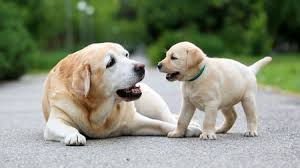

Prediction Caption: a dog with its head walking near a placed road


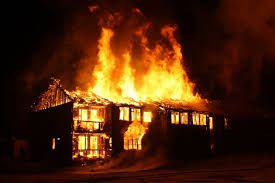

Prediction Caption: an old and shadow along a cross on it


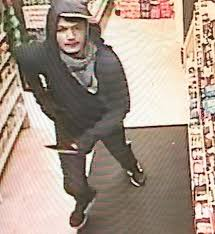

Prediction Caption: the man in in an checking his back in the partially hat is pack a tether


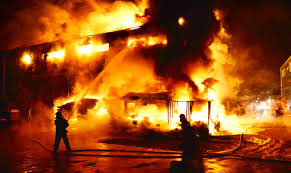

Prediction Caption: a city street crossing at street holding <unk> traffic light and fire


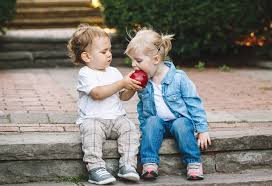

Prediction Caption: two cabinets sit in front of a fence with a little cabinets wearing a building


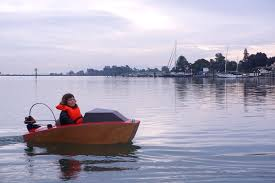

Prediction Caption: very is an image of a group of six cool near water
Train_loss
Epoch 1 Batch 0 Loss 0.6798
Epoch 1 Batch 100 Loss 0.6234
Epoch 1 Batch 200 Loss 0.5962
Epoch 1 Batch 300 Loss 0.6016
Epoch 1 Batch 400 Loss 0.6075
Epoch 1 Batch 500 Loss 0.5775
Epoch 1 Batch 600 Loss 0.5957
Epoch 1 Batch 700 Loss 0.5859
Epoch 1 Batch 800 Loss 0.5500
Epoch 1 Batch 900 Loss 0.5848
Epoch 1 Batch 1000 Loss 0.5523
Epoch 1 Batch 1100 Loss 0.5659
Epoch 1 Batch 1200 Loss 0.5591
Epoch 1 Batch 1300 Loss 0.5993
Epoch 1 Batch 1400 Loss 0.5699
Epoch 1 Batch 1500 Loss 0.5732
Epoch 1 Batch 1600 Loss 0.5633
Epoch 1 Batch 1700 Loss 0.5628
Epoch 1 Batch 1800 Loss 0.5695
Epoch 1 Loss 0.578214
Time taken for 1 epoch 695.3581504821777 sec

Validation loss
Epoch 1 Batch 0 Loss 1.6737
Epoch 1 Batch 100 Loss 1.7453
Epoch 1 Batch 200 Loss 1.7177
Epoch 1 Batch 300 Loss 1.6955
Epoch 1 Batch 400 Loss 1.7337
Epoch 1 Loss 4.032051
Time taken for 1 epoch 982.4299175739288 sec



A Jupyter Widget

A Jupyter Widget

/home/seeds/iconms12/tmp/yes/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/home/seeds/iconms12/tmp/yes/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/home/seeds/iconms12/tmp/yes/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


[['a', 'person', 'holds', 'a', 'half', 'eaten', 'sandwich', 'in', 'her', 'hand'], ['a', 'herd', 'of', 'zebra', 'standing', 'on', 'a', 'grass', 'covered', 'hillside'], ['a', 'group', 'of', 'zebras', 'grazing', 'dry', 'brush', 'and', 'grass', 'in', 'a', 'field'], ['a', 'group', 'of', 'zebras', 'stand', 'in', 'front', 'of', 'trees', 'and', 'shrubs'], ['a', 'group', 'of', 'zebra', "'s", 'standing', 'in', 'a', 'field', 'in', 'front', 'of', 'some', 'trees']]
['zebras', 'are', 'walking', 'together', 'in', 'a', 'field']



A Jupyter Widget


[0.4297389362854454, 0.27571747754984316, 0.11024561838730472, 0.042148490700381534, 0.16446512660591428, 0.22044148899029065, 0.09925095762798487, 0.07876123686272057, 0.29698405575833425]
1


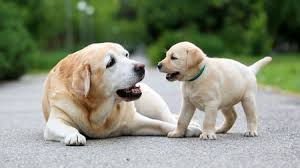

Prediction Caption: a white lab penguin on dirt road with reigns


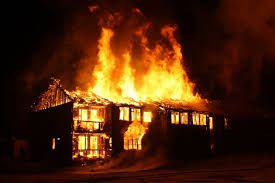

Prediction Caption: a building is burning fire broke out


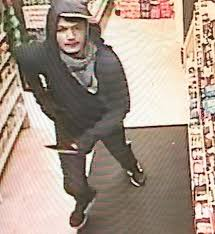

Prediction Caption: a montage of men with a flag and a pair of skis taking a picture


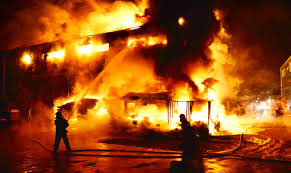

Prediction Caption: an overview burning on the broke out of each other side


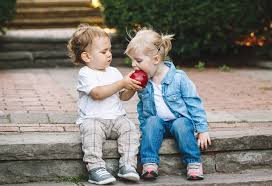

Prediction Caption: a young boy treats on a stone steps holding a toddler on an area


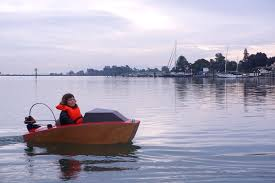

Prediction Caption: a boat in types of white
Train_loss
Epoch 2 Batch 0 Loss 0.5448
Epoch 2 Batch 100 Loss 0.5183
Epoch 2 Batch 200 Loss 0.4994
Epoch 2 Batch 300 Loss 0.5482
Epoch 2 Batch 400 Loss 0.5309
Epoch 2 Batch 500 Loss 0.5269
Epoch 2 Batch 600 Loss 0.5147
Epoch 2 Batch 700 Loss 0.5585
Epoch 2 Batch 800 Loss 0.5139
Epoch 2 Batch 900 Loss 0.5539
Epoch 2 Batch 1000 Loss 0.5291
Epoch 2 Batch 1100 Loss 0.5286
Epoch 2 Batch 1200 Loss 0.5053
Epoch 2 Batch 1300 Loss 0.5408
Epoch 2 Batch 1400 Loss 0.5360
Epoch 2 Batch 1500 Loss 0.5253
Epoch 2 Batch 1600 Loss 0.5352
Epoch 2 Batch 1700 Loss 0.5633
Epoch 2 Batch 1800 Loss 0.5252
Epoch 2 Loss 0.531199
Time taken for 1 epoch 635.3301684856415 sec

Validation loss
Epoch 2 Batch 0 Loss 1.6725
Epoch 2 Batch 100 Loss 1.7314
Epoch 2 Batch 200 Loss 1.7780
Epoch 2 Batch 300 Loss 1.7334
Epoch 2 Batch 400 Loss 1.7302
Epoch 2 Loss 3.862235
Time taken for 1 epoch 922.9301459789276 sec



A Jupyter Widget

A Jupyter Widget

[['a', 'person', 'holds', 'a', 'half', 'eaten', 'sandwich', 'in', 'her', 'hand'], ['a', 'herd', 'of', 'zebra', 'standing', 'on', 'a', 'grass', 'covered', 'hillside'], ['a', 'group', 'of', 'zebras', 'grazing', 'dry', 'brush', 'and', 'grass', 'in', 'a', 'field'], ['a', 'group', 'of', 'zebras', 'stand', 'in', 'front', 'of', 'trees', 'and', 'shrubs'], ['a', 'group', 'of', 'zebra', "'s", 'standing', 'in', 'a', 'field', 'in', 'front', 'of', 'some', 'trees']]
['five', 'zebra', 'standing', 'in', 'tall', 'grassy', 'field', 'eating', 'leaves']



A Jupyter Widget


[0.4283143286179058, 0.2748718037043195, 0.10951469822207185, 0.041803520986162045, 0.16370682105043338, 0.22030381361731202, 0.09942495407977525, 0.07866671512149874, 0.29753270441890894]
2


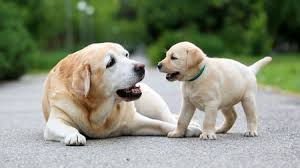

Prediction Caption: a group of dogs fighting each other


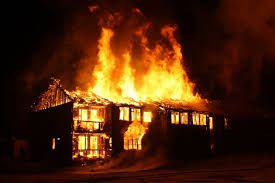

Prediction Caption: a lit fire broke out from a person standing on fire


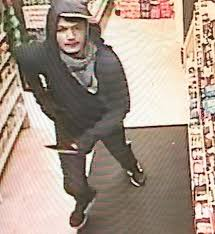

Prediction Caption: a series of photos of photos of photos side down joker mime costume boxes of scissors


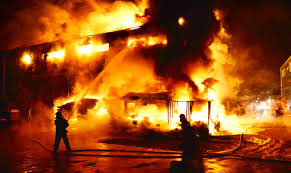

Prediction Caption: fire broke out


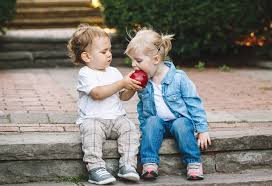

Prediction Caption: two little children sitting and the two girls sit and standing in the grass


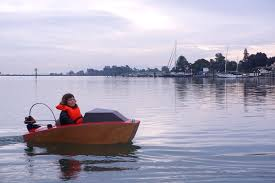

Prediction Caption: an open rowboat is loaded with many other boats
Train_loss
Epoch 3 Batch 0 Loss 0.5241
Epoch 3 Batch 100 Loss 0.5186
Epoch 3 Batch 200 Loss 0.5051
Epoch 3 Batch 300 Loss 0.5181
Epoch 3 Batch 400 Loss 0.4927
Epoch 3 Batch 500 Loss 0.5157
Epoch 3 Batch 600 Loss 0.5457
Epoch 3 Batch 700 Loss 0.5454
Epoch 3 Batch 800 Loss 0.4926
Epoch 3 Batch 900 Loss 0.5244
Epoch 3 Batch 1000 Loss 0.5130
Epoch 3 Batch 1100 Loss 0.4893
Epoch 3 Batch 1200 Loss 0.5047
Epoch 3 Batch 1300 Loss 0.5221
Epoch 3 Batch 1400 Loss 0.5274
Epoch 3 Batch 1500 Loss 0.4973
Epoch 3 Batch 1600 Loss 0.5068
Epoch 3 Batch 1700 Loss 0.5111
Epoch 3 Batch 1800 Loss 0.5232
Epoch 3 Loss 0.511642
Time taken for 1 epoch 638.0350244045258 sec

Validation loss
Epoch 3 Batch 0 Loss 1.7382
Epoch 3 Batch 100 Loss 1.7663
Epoch 3 Batch 200 Loss 1.7765
Epoch 3 Batch 300 Loss 1.7638
Epoch 3 Batch 400 Loss 1.7310
Epoch 3 Loss 3.798018
Time taken for 1 epoch 925.4802632331848 sec



A Jupyter Widget

A Jupyter Widget

[['a', 'person', 'holds', 'a', 'half', 'eaten', 'sandwich', 'in', 'her', 'hand'], ['a', 'herd', 'of', 'zebra', 'standing', 'on', 'a', 'grass', 'covered', 'hillside'], ['a', 'group', 'of', 'zebras', 'grazing', 'dry', 'brush', 'and', 'grass', 'in', 'a', 'field'], ['a', 'group', 'of', 'zebras', 'stand', 'in', 'front', 'of', 'trees', 'and', 'shrubs'], ['a', 'group', 'of', 'zebra', "'s", 'standing', 'in', 'a', 'field', 'in', 'front', 'of', 'some', 'trees']]
['three', 'zebras', 'enjoy', 'each', 'other', 'in', 'grass']



A Jupyter Widget


[0.4408322998785135, 0.2807340380181462, 0.1134132435418004, 0.04396326247114716, 0.1680912669764997, 0.22651411106569666, 0.10089083786441252, 0.07901547260814525, 0.29359066792340516]
3


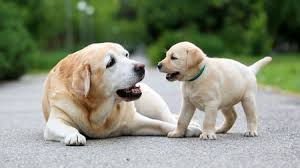

Prediction Caption: a dog among a duck


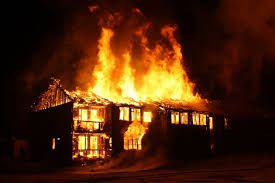

Prediction Caption: a building is burning building the fire in the background


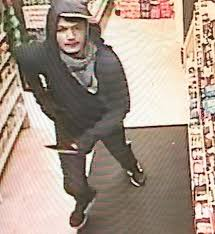

Prediction Caption: a masked man leans up against a stand of rink with a knife


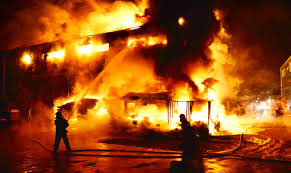

Prediction Caption: a lazy vehicle in flames


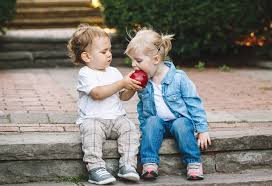

Prediction Caption: a small boys who are sitting on the steps


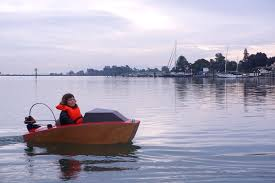

Prediction Caption: a boat sits on the lake
Train_loss
Epoch 4 Batch 0 Loss 0.5233
Epoch 4 Batch 100 Loss 0.4827
Epoch 4 Batch 200 Loss 0.5089
Epoch 4 Batch 300 Loss 0.5006
Epoch 4 Batch 400 Loss 0.4965
Epoch 4 Batch 500 Loss 0.4922
Epoch 4 Batch 600 Loss 0.4919
Epoch 4 Batch 700 Loss 0.5041
Epoch 4 Batch 800 Loss 0.5006
Epoch 4 Batch 900 Loss 0.5267
Epoch 4 Batch 1000 Loss 0.5086
Epoch 4 Batch 1100 Loss 0.4763
Epoch 4 Batch 1200 Loss 0.5002
Epoch 4 Batch 1300 Loss 0.5278
Epoch 4 Batch 1400 Loss 0.4870
Epoch 4 Batch 1500 Loss 0.4807
Epoch 4 Batch 1600 Loss 0.5011
Epoch 4 Batch 1700 Loss 0.5094
Epoch 4 Batch 1800 Loss 0.4892
Epoch 4 Loss 0.497490
Time taken for 1 epoch 637.7029213905334 sec

Validation loss
Epoch 4 Batch 0 Loss 1.7187
Epoch 4 Batch 100 Loss 1.7773
Epoch 4 Batch 200 Loss 1.7306
Epoch 4 Batch 300 Loss 1.7474
Epoch 4 Batch 400 Loss 1.7748
Epoch 4 Loss 3.754974
Time taken for 1 epoch 924.9994614124298 sec



A Jupyter Widget

A Jupyter Widget

[['a', 'person', 'holds', 'a', 'half', 'eaten', 'sandwich', 'in', 'her', 'hand'], ['a', 'herd', 'of', 'zebra', 'standing', 'on', 'a', 'grass', 'covered', 'hillside'], ['a', 'group', 'of', 'zebras', 'grazing', 'dry', 'brush', 'and', 'grass', 'in', 'a', 'field'], ['a', 'group', 'of', 'zebras', 'stand', 'in', 'front', 'of', 'trees', 'and', 'shrubs'], ['a', 'group', 'of', 'zebra', "'s", 'standing', 'in', 'a', 'field', 'in', 'front', 'of', 'some', 'trees']]
['a', 'herd', 'of', 'zebra', 'standing', 'next', 'to', 'each', 'other']



A Jupyter Widget


[0.4358068722046848, 0.2789236389973118, 0.11201057139133656, 0.04309399773282259, 0.16663805544169297, 0.2235114550728418, 0.10018071501947859, 0.0788225045079384, 0.2956743810651269]
4


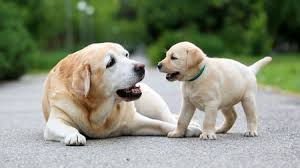

Prediction Caption: a group of different color dogs are crossing the snow


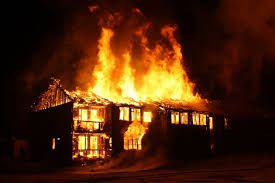

Prediction Caption: a brick apartment building at night sky in the background


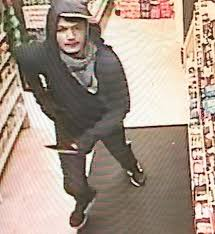

Prediction Caption: a masked man with a knife and sitting <unk> and board


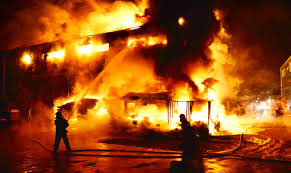

Prediction Caption: a fire broke out at the right above and parked


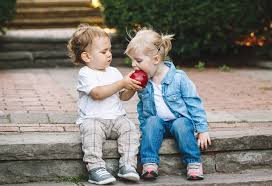

Prediction Caption: a man sitting on the steps in the curb


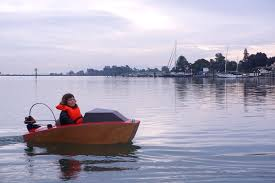

Prediction Caption: a colorful canoe boat on a lake near an <unk> dock near several boats in a body of water
Train_loss
Epoch 5 Batch 0 Loss 0.4653
Epoch 5 Batch 100 Loss 0.5262
Epoch 5 Batch 200 Loss 0.4726
Epoch 5 Batch 300 Loss 0.4895
Epoch 5 Batch 400 Loss 0.4968
Epoch 5 Batch 500 Loss 0.4827
Epoch 5 Batch 600 Loss 0.4922
Epoch 5 Batch 700 Loss 0.4914
Epoch 5 Batch 800 Loss 0.4878
Epoch 5 Batch 900 Loss 0.4853
Epoch 5 Batch 1000 Loss 0.4969
Epoch 5 Batch 1100 Loss 0.5020
Epoch 5 Batch 1200 Loss 0.4749
Epoch 5 Batch 1300 Loss 0.4731
Epoch 5 Batch 1400 Loss 0.4728
Epoch 5 Batch 1500 Loss 0.5043
Epoch 5 Batch 1600 Loss 0.4891
Epoch 5 Batch 1700 Loss 0.4968
Epoch 5 Batch 1800 Loss 0.4895
Epoch 5 Loss 0.487242
Time taken for 1 epoch 637.6761739253998 sec

Validation loss
Epoch 5 Batch 0 Loss 1.7906
Epoch 5 Batch 100 Loss 1.7418
Epoch 5 Batch 200 Loss 1.7377
Epoch 5 Batch 300 Loss 1.7923
Epoch 5 Batch 400 Loss 1.7333
Epoch 5 Loss 3.717677
Time taken for 1 epoch 924.9535076618195 sec



A Jupyter Widget

A Jupyter Widget

[['a', 'person', 'holds', 'a', 'half', 'eaten', 'sandwich', 'in', 'her', 'hand'], ['a', 'herd', 'of', 'zebra', 'standing', 'on', 'a', 'grass', 'covered', 'hillside'], ['a', 'group', 'of', 'zebras', 'grazing', 'dry', 'brush', 'and', 'grass', 'in', 'a', 'field'], ['a', 'group', 'of', 'zebras', 'stand', 'in', 'front', 'of', 'trees', 'and', 'shrubs'], ['a', 'group', 'of', 'zebra', "'s", 'standing', 'in', 'a', 'field', 'in', 'front', 'of', 'some', 'trees']]
['three', 'zebra', "'s", 'standing', 'next', 'to', 'each', 'other']



A Jupyter Widget


[0.4385098123013293, 0.2806324405775748, 0.11309340786235882, 0.04381451315255256, 0.16784753024990132, 0.22568766794834214, 0.10047571297834461, 0.0789169486700039, 0.2946796621684506]
5


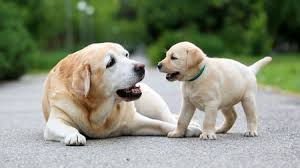

Prediction Caption: a dog stands on a dirt road


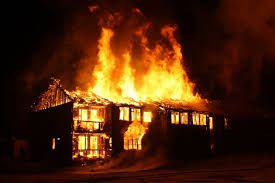

Prediction Caption: a church bench siting on fire <unk> one


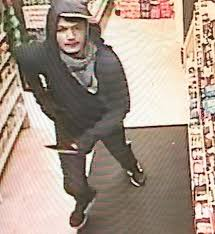

Prediction Caption: a man with a suit


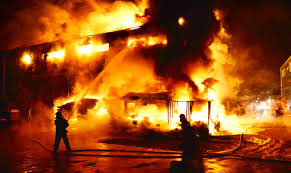

Prediction Caption: the building is on fire


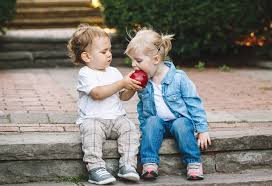

Prediction Caption: a couple of young boy sitting on wooden steps with other poses


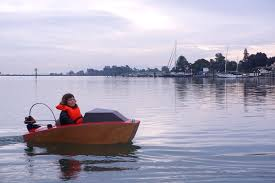

Prediction Caption: a black white and a boat sits on the lake
Train_loss
Epoch 6 Batch 0 Loss 0.4797
Epoch 6 Batch 100 Loss 0.4897
Epoch 6 Batch 200 Loss 0.4428
Epoch 6 Batch 300 Loss 0.4822
Epoch 6 Batch 400 Loss 0.4733
Epoch 6 Batch 500 Loss 0.4733
Epoch 6 Batch 600 Loss 0.4859
Epoch 6 Batch 700 Loss 0.4739
Epoch 6 Batch 800 Loss 0.4839
Epoch 6 Batch 900 Loss 0.4892
Epoch 6 Batch 1000 Loss 0.4750
Epoch 6 Batch 1100 Loss 0.4811
Epoch 6 Batch 1200 Loss 0.4820
Epoch 6 Batch 1300 Loss 0.5092
Epoch 6 Batch 1400 Loss 0.4771
Epoch 6 Batch 1500 Loss 0.4828
Epoch 6 Batch 1600 Loss 0.4966
Epoch 6 Batch 1700 Loss 0.4998
Epoch 6 Batch 1800 Loss 0.4925
Epoch 6 Loss 0.477271
Time taken for 1 epoch 638.7552506923676 sec

Validation loss
Epoch 6 Batch 0 Loss 1.7409
Epoch 6 Batch 100 Loss 1.7953
Epoch 6 Batch 200 Loss 1.7655
Epoch 6 Batch 300 Loss 1.7385
Epoch 6 Batch 400 Loss 1.7342
Epoch 6 Loss 3.688668
Time taken for 1 epoch 926.2982885837555 sec



A Jupyter Widget

A Jupyter Widget

[['a', 'person', 'holds', 'a', 'half', 'eaten', 'sandwich', 'in', 'her', 'hand'], ['a', 'herd', 'of', 'zebra', 'standing', 'on', 'a', 'grass', 'covered', 'hillside'], ['a', 'group', 'of', 'zebras', 'grazing', 'dry', 'brush', 'and', 'grass', 'in', 'a', 'field'], ['a', 'group', 'of', 'zebras', 'stand', 'in', 'front', 'of', 'trees', 'and', 'shrubs'], ['a', 'group', 'of', 'zebra', "'s", 'standing', 'in', 'a', 'field', 'in', 'front', 'of', 'some', 'trees']]
['a', 'group', 'of', 'zebra', 'standing', 'in', 'a', 'field', 'with', 'a', 'single', 'tree']



A Jupyter Widget


[0.4419207366751148, 0.28299220537517467, 0.11455804557506837, 0.04443344175370241, 0.16966046275091523, 0.22628252164231763, 0.10158067174662039, 0.07878851530613319, 0.29501730801521436]
6


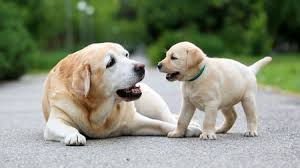

Prediction Caption: a small furry dog walking across a snowy day in front of a toy


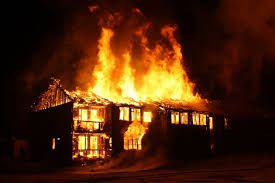

Prediction Caption: side fire broke out


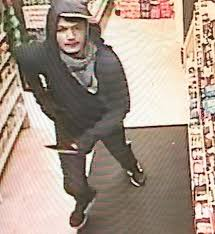

Prediction Caption: a masked man with a knife and peers in the background posing for the camera


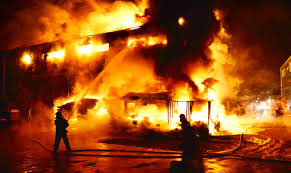

Prediction Caption: a burning building in flames


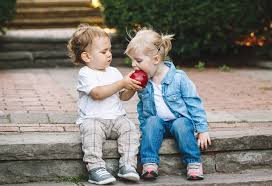

Prediction Caption: a girl sitting on a stone steps


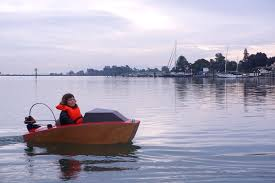

Prediction Caption: person next to three people with small boats sitting on a lake
Train_loss
Epoch 7 Batch 0 Loss 0.4591
Epoch 7 Batch 100 Loss 0.4970
Epoch 7 Batch 200 Loss 0.4504
Epoch 7 Batch 300 Loss 0.4394
Epoch 7 Batch 400 Loss 0.4658
Epoch 7 Batch 500 Loss 0.4719
Epoch 7 Batch 600 Loss 0.4581
Epoch 7 Batch 700 Loss 0.4988
Epoch 7 Batch 800 Loss 0.4633
Epoch 7 Batch 900 Loss 0.4664
Epoch 7 Batch 1000 Loss 0.4580
Epoch 7 Batch 1100 Loss 0.4721
Epoch 7 Batch 1200 Loss 0.4697
Epoch 7 Batch 1300 Loss 0.4840
Epoch 7 Batch 1400 Loss 0.4716
Epoch 7 Batch 1500 Loss 0.4675
Epoch 7 Batch 1600 Loss 0.4515
Epoch 7 Batch 1700 Loss 0.4974
Epoch 7 Batch 1800 Loss 0.4637
Epoch 7 Loss 0.469465
Time taken for 1 epoch 637.3889985084534 sec

Validation loss
Epoch 7 Batch 0 Loss 1.7622
Epoch 7 Batch 100 Loss 1.7989
Epoch 7 Batch 200 Loss 1.7908
Epoch 7 Batch 300 Loss 1.7574
Epoch 7 Batch 400 Loss 1.7705
Epoch 7 Loss 3.656436
Time taken for 1 epoch 925.5887112617493 sec



A Jupyter Widget

A Jupyter Widget

[['a', 'person', 'holds', 'a', 'half', 'eaten', 'sandwich', 'in', 'her', 'hand'], ['a', 'herd', 'of', 'zebra', 'standing', 'on', 'a', 'grass', 'covered', 'hillside'], ['a', 'group', 'of', 'zebras', 'grazing', 'dry', 'brush', 'and', 'grass', 'in', 'a', 'field'], ['a', 'group', 'of', 'zebras', 'stand', 'in', 'front', 'of', 'trees', 'and', 'shrubs'], ['a', 'group', 'of', 'zebra', "'s", 'standing', 'in', 'a', 'field', 'in', 'front', 'of', 'some', 'trees']]
['two', 'zebras', 'stand', 'in', 'the', 'foreground', 'with', 'trees', 'in', 'the', 'background']



A Jupyter Widget


[0.4345640184657301, 0.2778561950379427, 0.11165435882825714, 0.043153667746276644, 0.16602794134280313, 0.2230625201790221, 0.09863047204757952, 0.07902426736650443, 0.2950125761729653]
7


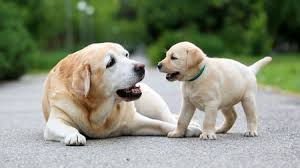

Prediction Caption: two dogs work important fur he's never use of dry grass


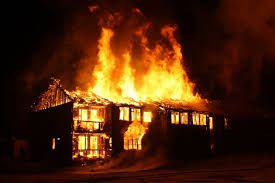

Prediction Caption: a burning building on fire


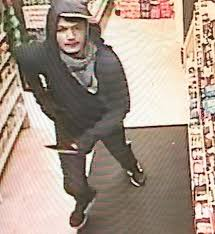

Prediction Caption: a man in a strange uniform smiles


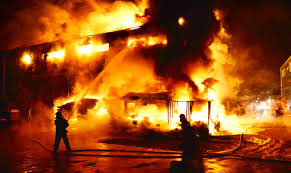

Prediction Caption: the building is making some fire broke itself


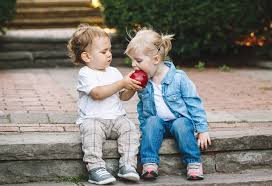

Prediction Caption: a boy sitting on some stairs with christmas trees in a few shades of the phone


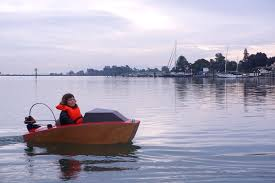

Prediction Caption: a person in a boat in a body of water near a harbor
Train_loss
Epoch 8 Batch 0 Loss 0.4667
Epoch 8 Batch 100 Loss 0.5010
Epoch 8 Batch 200 Loss 0.4810
Epoch 8 Batch 300 Loss 0.4536
Epoch 8 Batch 400 Loss 0.4692
Epoch 8 Batch 500 Loss 0.4694
Epoch 8 Batch 600 Loss 0.4519
Epoch 8 Batch 700 Loss 0.4989
Epoch 8 Batch 800 Loss 0.4486
Epoch 8 Batch 900 Loss 0.4704
Epoch 8 Batch 1000 Loss 0.4620
Epoch 8 Batch 1100 Loss 0.4610
Epoch 8 Batch 1200 Loss 0.4529
Epoch 8 Batch 1300 Loss 0.4925
Epoch 8 Batch 1400 Loss 0.4458
Epoch 8 Batch 1500 Loss 0.4787
Epoch 8 Batch 1600 Loss 0.4720
Epoch 8 Batch 1700 Loss 0.4679
Epoch 8 Batch 1800 Loss 0.4669
Epoch 8 Loss 0.462960
Time taken for 1 epoch 637.4096941947937 sec

Validation loss
Epoch 8 Batch 0 Loss 1.8683
Epoch 8 Batch 100 Loss 1.8135
Epoch 8 Batch 200 Loss 1.7762
Epoch 8 Batch 300 Loss 1.8051
Epoch 8 Batch 400 Loss 1.8167
Epoch 8 Loss 3.641338
Time taken for 1 epoch 924.5265941619873 sec



A Jupyter Widget

A Jupyter Widget

[['a', 'person', 'holds', 'a', 'half', 'eaten', 'sandwich', 'in', 'her', 'hand'], ['a', 'herd', 'of', 'zebra', 'standing', 'on', 'a', 'grass', 'covered', 'hillside'], ['a', 'group', 'of', 'zebras', 'grazing', 'dry', 'brush', 'and', 'grass', 'in', 'a', 'field'], ['a', 'group', 'of', 'zebras', 'stand', 'in', 'front', 'of', 'trees', 'and', 'shrubs'], ['a', 'group', 'of', 'zebra', "'s", 'standing', 'in', 'a', 'field', 'in', 'front', 'of', 'some', 'trees']]
['some', 'zebras', 'stand', 'in', 'a', 'forest']



A Jupyter Widget


[0.4387823366949049, 0.28069856988915803, 0.11309993737261967, 0.04383227726327462, 0.16802455375609723, 0.22549195359092214, 0.10148416102882571, 0.07871600100099659, 0.29555791625619465]
8


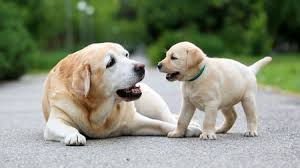

Prediction Caption: a house and beige color curiously attend in a dog


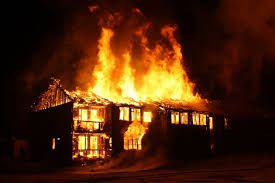

Prediction Caption: the building is burning building


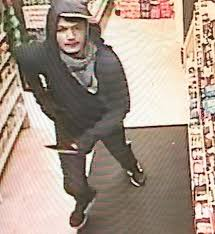

Prediction Caption: the man in a black that is going very both feet propped against a fence


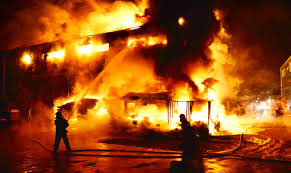

Prediction Caption: a burning building


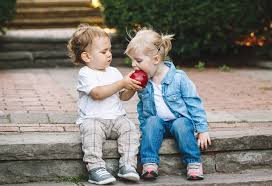

Prediction Caption: a young girl in the ground next to each other on the steps


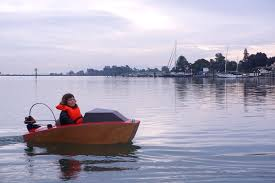

Prediction Caption: a man is standing on a small boat in the water
Train_loss
Epoch 9 Batch 0 Loss 0.4529
Epoch 9 Batch 100 Loss 0.4719
Epoch 9 Batch 200 Loss 0.4238
Epoch 9 Batch 300 Loss 0.4554
Epoch 9 Batch 400 Loss 0.4392
Epoch 9 Batch 500 Loss 0.4543
Epoch 9 Batch 600 Loss 0.4718
Epoch 9 Batch 700 Loss 0.4589
Epoch 9 Batch 800 Loss 0.4598
Epoch 9 Batch 900 Loss 0.4612
Epoch 9 Batch 1000 Loss 0.4257
Epoch 9 Batch 1100 Loss 0.4661
Epoch 9 Batch 1200 Loss 0.4497
Epoch 9 Batch 1300 Loss 0.4696
Epoch 9 Batch 1400 Loss 0.4427
Epoch 9 Batch 1500 Loss 0.4667
Epoch 9 Batch 1600 Loss 0.4675
Epoch 9 Batch 1700 Loss 0.4834
Epoch 9 Batch 1800 Loss 0.4437
Epoch 9 Loss 0.457167
Time taken for 1 epoch 638.9337301254272 sec

Validation loss
Epoch 9 Batch 0 Loss 1.8165
Epoch 9 Batch 100 Loss 1.8637
Epoch 9 Batch 200 Loss 1.8361
Epoch 9 Batch 300 Loss 1.8092
Epoch 9 Batch 400 Loss 1.8222
Epoch 9 Loss 3.649926
Time taken for 1 epoch 925.5213460922241 sec



A Jupyter Widget

A Jupyter Widget

[['a', 'person', 'holds', 'a', 'half', 'eaten', 'sandwich', 'in', 'her', 'hand'], ['a', 'herd', 'of', 'zebra', 'standing', 'on', 'a', 'grass', 'covered', 'hillside'], ['a', 'group', 'of', 'zebras', 'grazing', 'dry', 'brush', 'and', 'grass', 'in', 'a', 'field'], ['a', 'group', 'of', 'zebras', 'stand', 'in', 'front', 'of', 'trees', 'and', 'shrubs'], ['a', 'group', 'of', 'zebra', "'s", 'standing', 'in', 'a', 'field', 'in', 'front', 'of', 'some', 'trees']]
['zebras', 'are', 'standing', 'in', 'a', 'field', 'in', 'the', 'background']



A Jupyter Widget


[0.44378047492457734, 0.2842131959790649, 0.11475596466967469, 0.04448340458445789, 0.17021898114388662, 0.22703546330733648, 0.10130022669266685, 0.07875828100402243, 0.2954365238507069]
9


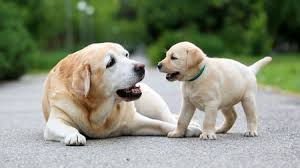

Prediction Caption: a group of dogs arrange with dogs on a pathway in his mouth


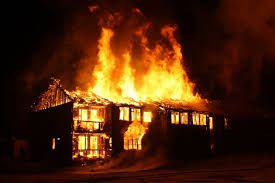

Prediction Caption: a burning building in flames


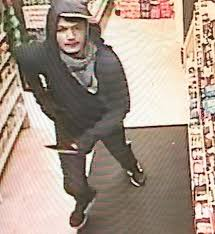

Prediction Caption: a man in a is posing next to a knife


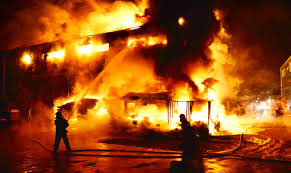

Prediction Caption: the building is burning in flames


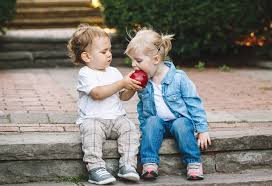

Prediction Caption: a girl sitting on stairs while many sitting next to each other in front of a brick wall


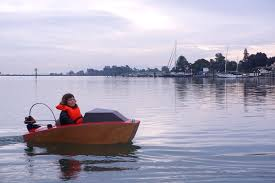

Prediction Caption: a lake in front of heavy spots in it
Train_loss
Epoch 10 Batch 0 Loss 0.4832
Epoch 10 Batch 100 Loss 0.4585
Epoch 10 Batch 200 Loss 0.4475
Epoch 10 Batch 300 Loss 0.4404
Epoch 10 Batch 400 Loss 0.4666
Epoch 10 Batch 500 Loss 0.4601
Epoch 10 Batch 600 Loss 0.4582
Epoch 10 Batch 700 Loss 0.4609
Epoch 10 Batch 800 Loss 0.4552
Epoch 10 Batch 900 Loss 0.4546
Epoch 10 Batch 1000 Loss 0.4518
Epoch 10 Batch 1100 Loss 0.4493
Epoch 10 Batch 1200 Loss 0.4476
Epoch 10 Batch 1300 Loss 0.4938
Epoch 10 Batch 1400 Loss 0.4684
Epoch 10 Batch 1500 Loss 0.4489
Epoch 10 Batch 1600 Loss 0.4408
Epoch 10 Batch 1700 Loss 0.4686
Epoch 10 Batch 1800 Loss 0.4658
Epoch 10 Loss 0.452023
Time taken for 1 epoch 638.9170365333557 sec

Validation loss
Epoch 10 Batch 0 Loss 1.8202
Epoch 10 Batch 100 Loss 1.8947
Epoch 10 Batch 200 Loss 1.7991
Epoch 10 Batch 300 Loss 1.7948
Epoch 10 Batch 400 Loss 1.8463
Epoch 10 Loss 3.640971
Time taken for 1 epoch 926.3721714019775 sec



A Jupyter Widget

A Jupyter Widget

[['a', 'person', 'holds', 'a', 'half', 'eaten', 'sandwich', 'in', 'her', 'hand'], ['a', 'herd', 'of', 'zebra', 'standing', 'on', 'a', 'grass', 'covered', 'hillside'], ['a', 'group', 'of', 'zebras', 'grazing', 'dry', 'brush', 'and', 'grass', 'in', 'a', 'field'], ['a', 'group', 'of', 'zebras', 'stand', 'in', 'front', 'of', 'trees', 'and', 'shrubs'], ['a', 'group', 'of', 'zebra', "'s", 'standing', 'in', 'a', 'field', 'in', 'front', 'of', 'some', 'trees']]
['a', 'group', 'of', 'zebras', 'standing', 'around', 'a', 'field', 'of', 'dry', 'grass']



A Jupyter Widget


[0.4415833415096669, 0.2834134006980641, 0.11405968174717304, 0.04406059512119212, 0.16967948529748902, 0.2266552001215078, 0.10378309672001627, 0.07834047110707817, 0.29717062407504713]


In [37]:
from IPython.display import Image as imga
import pandas as pd
start_epoch=0
EPOCHS = 10
a1=[]
a2=[]
a3=[]
a4=[]
mean_gram=[]
low=[]
high=[]
jaccard=[]
cosin=[]
euclidean=[]
manhattan=[]

def print_examples():
    path = "/home/seeds/iconms12/tmp/Image_cap/Test_img/"
    img_file = os.listdir(path)
    img_names = [file for file in img_file if file.endswith(".jpg")]
    
    for i in img_names:
        image=path+i
        display(imga(filename=image, width=300,height=200))
        result, attention_plot = evaluate(image)
        print ('Prediction Caption:', ' '.join(result[:-1]))
        
for epoch in range(start_epoch, EPOCHS):
    
    
    print(epoch)
    print_examples()
    
    start = time.time()
    total_loss = 0
    print("Train_loss")
    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(float(total_loss / num_steps))
    
    ckpt_manager.save() #2epoch마다 체크포인트 저장

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
      #val
    print("Validation loss")
    for (batch, (img_tensor, target)) in enumerate(v_dataset):
        batch_loss, t_loss = loss_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    v_loss_plot.append(float(total_loss / v_num_steps))

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/v_num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    h=print_caption()
    a1.append(f'{h[0]:.3f}')
    a2.append(f'{h[1]:.3f}')
    a3.append(f'{h[2]:.3f}')
    a4.append(f'{h[3]:.3f}')
    mean_gram.append(f'{h[4]:.3f}')
    jaccard.append(f'{h[5]:.3f}')
    cosin.append(f'{h[6]:.3f}')
    euclidean.append(f'{h[7]:.3f}')
    manhattan.append(f'{h[8]:.3f}')
    

dic={'epoch':range(1, EPOCHS+1),'val_loss':v_loss_plot,'train_loss':loss_plot,'1-gram' : a1,'2-gram' : a2,'3-gram' : a3,'4-gram' : a4,
'1-3 gram' : mean_gram, "jaccard":jaccard, "cosin":cosin, "manhattan":manhattan, "euclidean":euclidean}
#dic={'train_loss':loss_plot}
#dic={'epoch':range(1, EPOCHS+1),'val_loss':v_loss_plot,'train_loss':loss_plot}
b=pd.DataFrame(dic)
b.to_csv("final_model_trained.csv", mode='w', header=True)